In [1]:
import numpy as np
import pandas as pd
import random
random_seed = 0
random.seed(random_seed)
np.random.seed(random_seed)

In [2]:
train = pd.read_csv('/kaggle/input/demand-forecasting/train_0irEZ2H.csv')
test = pd.read_csv('/kaggle/input/demand-forecasting/test_nfaJ3J5.csv')

# **EDA On the Dataset**

In [3]:
train.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52


In [4]:
test.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku
0,212645,16/07/13,8091,216418,108.3000,108.3000,0,0
1,212646,16/07/13,8091,216419,109.0125,109.0125,0,0
2,212647,16/07/13,8091,216425,133.9500,133.9500,0,0
3,212648,16/07/13,8091,216233,133.9500,133.9500,0,0
4,212649,16/07/13,8091,217390,176.7000,176.7000,0,0


In [5]:
train.dtypes

record_ID            int64
week                object
store_id             int64
sku_id               int64
total_price        float64
base_price         float64
is_featured_sku      int64
is_display_sku       int64
units_sold           int64
dtype: object

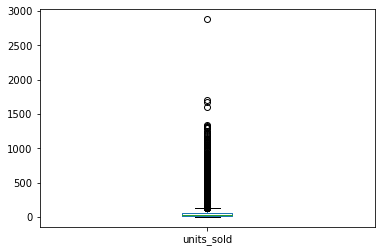

In [6]:
import matplotlib.pyplot as plt
train['units_sold'].plot(kind='box')

In [7]:
train['units_sold'].describe()

count    150150.000000
mean         51.674206
std          60.207904
min           1.000000
25%          20.000000
50%          35.000000
75%          62.000000
max        2876.000000
Name: units_sold, dtype: float64

1. here it can be seen that the model is highly succumbed to outliers so we have to take log transformation of the output column

In [8]:
train.isna().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        1
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

Only one missing value 

In [9]:
train['total_price'].replace(np.nan, train[train['total_price'].isnull()]['base_price'], inplace=True)

In [10]:
train.isna().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        0
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

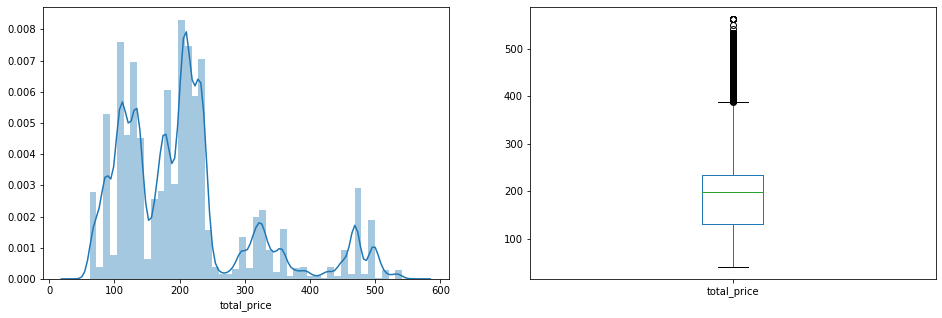

In [11]:
import seaborn as sns
plt.subplot(121)
df=train.dropna()
sns.distplot(train['total_price']);

plt.subplot(122)
train['total_price'].plot.box(figsize=(16,5))

plt.show()

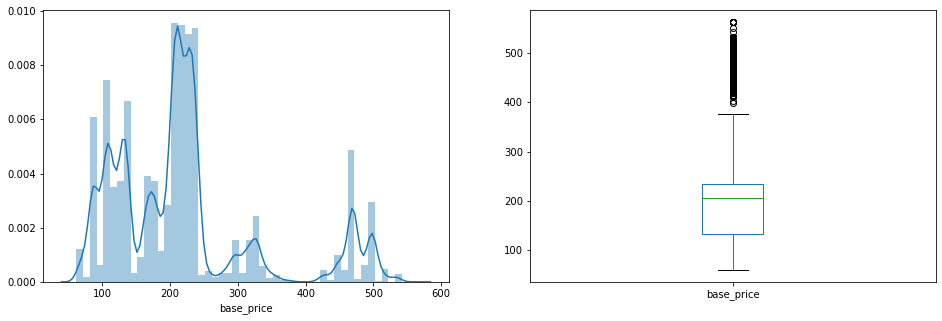

In [12]:
plt.subplot(121)
sns.distplot(train['base_price']);

plt.subplot(122)
train['base_price'].plot.box(figsize=(16,5))

plt.show()

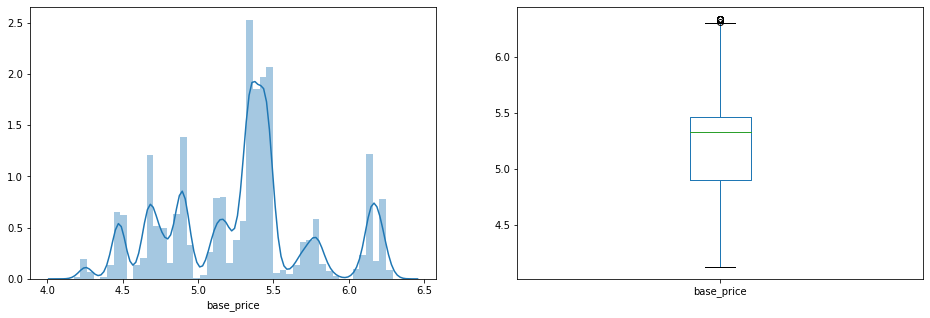

In [13]:
base_price_log=pd.DataFrame(np.log1p(train['base_price']))
base_price_log.head()
plt.subplot(121)

sns.distplot(base_price_log['base_price']);

plt.subplot(122)
base_price_log['base_price'].plot.box(figsize=(16,5))

plt.show()

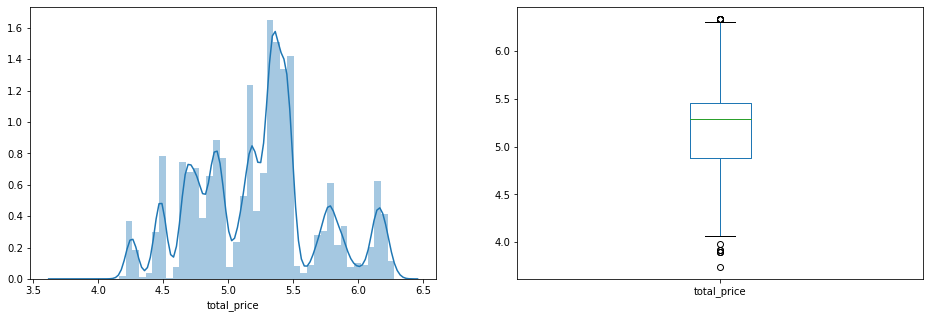

In [14]:
base_price_log=pd.DataFrame(np.log1p(train['total_price']))
base_price_log.head()
plt.subplot(121)

sns.distplot(base_price_log['total_price']);

plt.subplot(122)
base_price_log['total_price'].plot.box(figsize=(16,5))

plt.show()

In [15]:
train['total_price_log']=np.log1p(train['total_price'])
train['base_price_log']=np.log1p(train['base_price'])
test['total_price_log']=np.log1p(test['total_price'])
test['base_price_log']=np.log1p(test['base_price'])

In [16]:
units_sold_log=pd.DataFrame(np.log1p(train['units_sold']))

          units_sold
count  150150.000000
mean        3.585919
std         0.860773
min         0.693147
25%         3.044522
50%         3.583519
75%         4.143135
max         7.964503


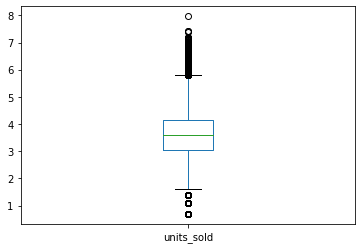

In [17]:
print(units_sold_log.describe())
units_sold_log.plot(kind='box')

In [18]:
units_sold_log.head()

,units_sold
0,3.044522
1,3.367296
2,2.995732
3,3.806662
4,3.970292


# Doing Binning and Bivariate Analysis

In [19]:
bins = [0,1,2, 3,4, 5, 6, 7, 8]
group = ['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8']
grps = pd.cut(units_sold_log['units_sold'],bins,labels=group)

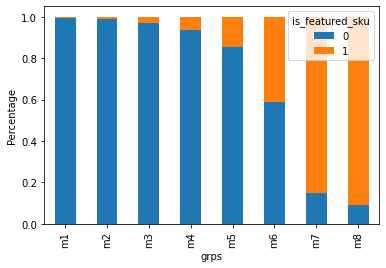

In [20]:
grps_bin = pd.crosstab(grps,train['is_featured_sku'])
grps_bin.div(grps_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.xlabel('grps')
P = plt.ylabel('Percentage')

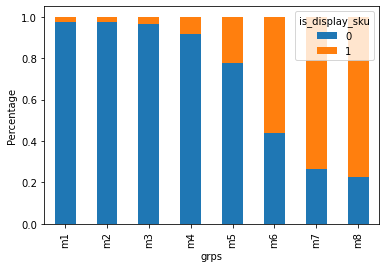

In [21]:
grps_bin = pd.crosstab(grps,train['is_display_sku'])
grps_bin.div(grps_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.xlabel('grps')
P = plt.ylabel('Percentage')

In [22]:
train['store_sku'] = (train['store_id'].astype('str') + "_" + train['sku_id'].astype('str'))
test['store_sku'] = (test['store_id'].astype('str') + "_" + test['sku_id'].astype('str'))
len(train['store_sku'].unique()) - len(test['store_sku'].unique())

0

In [23]:
assert len(np.intersect1d(train['store_sku'].unique(), test['store_sku'].unique())) == len(test['store_sku'].unique())

# observing data changes with time

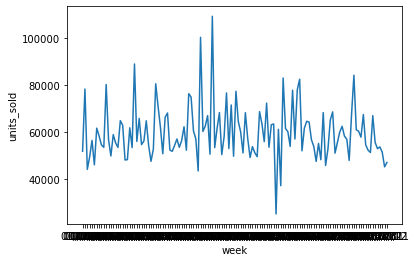

In [24]:
t1=pd.DataFrame((train.groupby('week').sum())['units_sold'])
t1.reset_index(inplace=True)
t1['date']=pd.DataFrame({'date':[date.split('/')[0] for date in t1['week']]})
t1['month']=pd.DataFrame({'month':[date.split('/')[1] for date in t1['week']]})
t1['year']=pd.DataFrame({'year':[date.split('/')[2] for date in t1['week']]})
t1['rev']=t1['year']+'/'+t1['month']+'/'+t1['date']
t1=t1.sort_values(by=['rev'])
t1['week']=t1['date']+'/'+t1['month']+'/'+t1['year']

import seaborn as sns
sns.lineplot(t1[:500]['week'], t1[:500]['units_sold'])

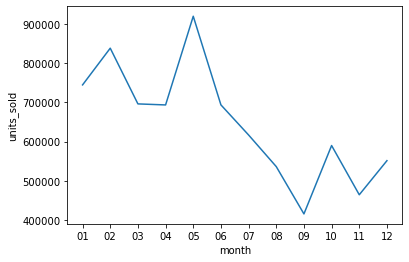

In [25]:
t2=pd.DataFrame((t1.groupby('month').sum()['units_sold']))
t2.reset_index(inplace=True)
import seaborn as sns
sns.lineplot(t2['month'], t2['units_sold'])

1. data show random pattern in sold_units with weeks proceeding.
2. Currently week data has to be further processed for creating relavent features.
3. sales vary widely according to the month. This may be associated with some special festivals or other occasions in that month.

In [26]:
t2

,month,units_sold
0,01,744543
1,02,838185
2,03,696049
3,04,693408
4,05,919661
5,06,693525
6,07,616755
7,08,536086
8,09,415389
9,10,589821


In [27]:
train.drop(['store_sku'], axis=1, inplace=True)

In [28]:
test.drop(['store_sku'], axis=1, inplace=True)

In [29]:
train.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,total_price_log,base_price_log
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20,4.605545,4.726170
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28,4.605545,4.605545
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19,4.904904,4.904904
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44,4.904904,4.904904
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52,4.956355,4.956355


# Feature Engineering

In [30]:
def gen_count_id(train,test,col,name):
    temp=train.groupby(col)['record_ID'].count().reset_index().rename(columns={'record_ID':name})
    train=pd.merge(train,temp,how='left',on=col)
    test=pd.merge(test,temp,how='left',on=col)
    train[name]=train[name].astype(float)
    test[name]=test[name].astype(float)
    train[name].fillna(np.median(temp[name]),inplace=True)
    test[name].fillna(np.median(temp[name]),inplace=True)
    return train,test

def gen_average_units(train,test,col,name):
    temp=train.groupby(col)['units_sold'].mean().reset_index().rename(columns={'units_sold':name})
    train=pd.merge(train,temp,how='left',on=col)
    test=pd.merge(test,temp,how='left',on=col)
    train[name].fillna(np.median(temp[name]),inplace=True)
    test[name].fillna(np.median(temp[name]),inplace=True)
    return train,test

def gen_average_price(train,test,col,price='base_price',name='name'):
    temp=train.groupby(col)[price].mean().reset_index().rename(columns={price:name})
    train=pd.merge(train,temp,how='left',on=col)
    test=pd.merge(test,temp,how='left',on=col)
    train[name].fillna(np.median(temp[name]),inplace=True)
    test[name].fillna(np.median(temp[name]),inplace=True)
    return train,test

In [31]:
train,test = gen_count_id(train,test,col=['sku_id','store_id'],name='count_id_sku_store') #Genearting count of records per 'sku-id & store-id' 
train,test = gen_count_id(train,test,col=['sku_id'],name='count_id_sku') #Genearting count of records per 'sku-id'
train,test = gen_count_id(train,test,col=['store_id'],name='count_id_store') #Genearting count of records per 'store-id'

train,test = gen_average_units(train,test,col=['sku_id','store_id'],name='count_sku_store_id') #Genearting average units sold per 'sku-id & store-id'
train,test = gen_average_units(train,test,col=['store_id'],name='count_store_id') #Genearting average units sold per 'store-id'
train,test = gen_average_units(train,test,col=['sku_id'],name='count_sku_id') #Genearting average units sold per 'sku-id'

train,test = gen_average_price(train,test,col=['sku_id','store_id'],price='base_price',name='price_sku_store') #Genearting average base price per 'sku-id & store-id'
train,test = gen_average_price(train,test,col=['sku_id','store_id'],price='total_price',name='price_to_sku_store') #Genearting average total price per 'sku-id & store-id'
train,test = gen_average_price(train,test,col=['store_id'],price='base_price',name='price_store_id') #Genearting average base price per 'store-id'
train,test = gen_average_price(train,test,col=['sku_id'],price='base_price',name='price_sku_id') #Genearting average base price per 'sku-id'
train,test = gen_average_price(train,test,col=['store_id'],price='total_price',name='price_to_store_id') #Genearting average total price per 'store-id'
train,test = gen_average_price(train,test,col=['sku_id'],price='total_price',name='price_to_sku_id') #Genearting average total price per 'sku-id'

In [32]:
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.m_estimate import MEstimateEncoder

1. week1 column for analyzing the variation from the start of the time right from the first week
2. week_num for analyzing the particular week of the year
3. week_num1 for analyzing the particular week of the month
4. price_diff_percent feature representing changes from the base price
5. month for analyzing the particular month of the year

In [33]:
#Converting week feature
le = OrdinalEncoder()
train['week_1']=le.fit_transform(train['week'])
le = OrdinalEncoder()
test['week_1']=le.fit_transform(test['week'])+130

#Creating week number feature
train['week_num']=train.week_1%52
test['week_num']=test.week_1%52

train['week_num1']=train.week_1%4
test['week_num1']=test.week_1%4

#Creating feature: percent difference between base price and checkout price.
train['price_diff_percent'] = (train['base_price'] - train['total_price']) / train['base_price']
test['price_diff_percent'] = (test['base_price'] - test['total_price']) / test['base_price']

# creating feature for month
train['month']=pd.DataFrame({'month':[date.split('/')[1] for date in train['week']]})
test['month']=pd.DataFrame({'month':[date.split('/')[1] for date in test['week']]})
le = OrdinalEncoder()
train['month']=le.fit_transform(train['month'])
le = OrdinalEncoder()
test['month']=le.fit_transform(test['month'])

In [34]:
train.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,total_price_log,...,price_to_sku_store,price_store_id,price_sku_id,price_to_store_id,price_to_sku_id,week_1,week_num,week_num1,price_diff_percent,month
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20,4.605545,...,102.117692,181.312372,94.688268,172.272756,91.982702,1,1,1,0.11465,1
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28,4.605545,...,102.473942,181.312372,94.908763,172.272756,92.349162,1,1,1,0.00000,1
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19,4.904904,...,126.671538,181.312372,128.285210,172.272756,125.156355,1,1,1,0.00000,1
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44,4.904904,...,126.167308,181.312372,128.101871,172.272756,124.942208,1,1,1,0.00000,1
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52,4.956355,...,152.968269,181.312372,158.990538,172.272756,150.867334,1,1,1,0.00000,1


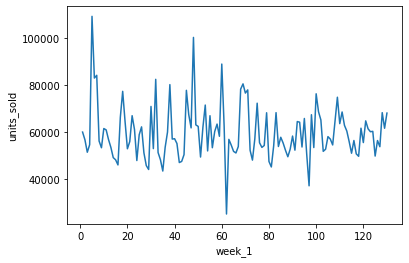

In [35]:
t1=pd.DataFrame((train.groupby('week_1').sum())['units_sold'])
t1.reset_index(inplace=True)

import seaborn as sns
sns.lineplot(t1['week_1'], t1['units_sold'])

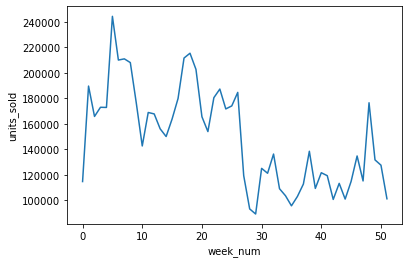

In [36]:
t1=pd.DataFrame((train.groupby('week_num').sum())['units_sold'])
t1.reset_index(inplace=True)

import seaborn as sns
sns.lineplot(t1['week_num'], t1['units_sold'])

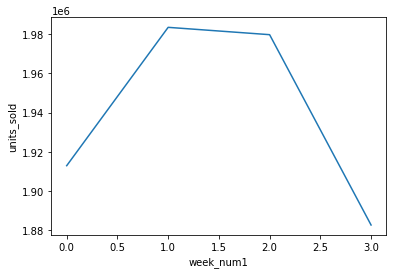

In [37]:
t1=pd.DataFrame((train.groupby('week_num1').sum())['units_sold'])
t1.reset_index(inplace=True)

import seaborn as sns
sns.lineplot(t1['week_num1'], t1['units_sold'])

1. sale is fluctuating with weeks varying from start
2. sale is varying with the year
3. sale is very high in the middle of the month

,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,total_price_log,base_price_log,...,price_to_sku_store,price_store_id,price_sku_id,price_to_store_id,price_to_sku_id,week_1,week_num,week_num1,price_diff_percent,month
record_ID,1.000000,7.464429e-03,-4.772670e-04,0.008497,0.018932,0.031358,0.020428,-0.010616,0.015421,0.014721,...,-1.636201e-04,-1.510709e-03,-1.973126e-04,-1.545026e-03,-1.991110e-04,9.999697e-01,8.400803e-02,-5.803834e-03,0.003130,6.584549e-02
store_id,0.007464,1.000000e+00,-6.862856e-02,-0.038308,-0.038848,-0.008729,0.013440,-0.004372,-0.038314,-0.039121,...,-3.991551e-02,-2.559208e-01,-4.271750e-02,-2.605978e-01,-4.278457e-02,3.146481e-19,1.046707e-16,-3.365127e-19,-0.004788,2.661661e-15
sku_id,-0.000477,-6.862856e-02,1.000000e+00,0.119327,0.119068,-0.022255,0.014911,-0.184380,0.122918,0.122765,...,1.243354e-01,1.281017e-01,1.204166e-01,1.280733e-01,1.248432e-01,-1.854818e-19,-2.813234e-18,-4.078346e-21,0.006932,-8.508359e-17
total_price,0.008497,-3.830780e-02,1.193275e-01,1.000000,0.958886,0.050348,-0.065935,-0.235634,0.958053,0.925505,...,9.597221e-01,1.462423e-01,9.541683e-01,1.469997e-01,9.558186e-01,8.653363e-03,-1.571045e-04,-5.510707e-03,-0.079330,-1.444323e-03
base_price,0.018932,-3.884811e-02,1.190677e-01,0.958886,1.000000,0.214333,0.051909,-0.140032,0.922356,0.958642,...,9.915482e-01,1.517974e-01,9.887974e-01,1.510153e-01,9.870902e-01,1.909201e-02,4.949666e-03,-5.592840e-04,0.180510,5.776236e-03
is_featured_sku,0.031358,-8.729370e-03,-2.225491e-02,0.050348,0.214333,1.000000,0.426243,0.337751,0.055316,0.194962,...,2.130560e-01,2.290823e-02,2.199742e-01,2.467571e-02,2.153824e-01,3.139232e-02,1.120258e-03,-2.486778e-03,0.546044,-9.845390e-04
is_display_sku,0.020428,1.343959e-02,1.491057e-02,-0.065935,0.051909,0.426243,1.000000,0.362662,-0.095097,0.005290,...,4.430313e-02,3.762611e-02,4.475284e-02,3.082896e-02,3.974838e-02,2.032127e-02,-4.851270e-02,3.298669e-03,0.381250,-4.677813e-02
units_sold,-0.010616,-4.371507e-03,-1.843798e-01,-0.235634,-0.140032,0.337751,0.362662,1.000000,-0.227536,-0.126832,...,-1.445885e-01,1.600899e-01,-1.530347e-01,1.434003e-01,-1.572807e-01,-1.068250e-02,-9.839942e-03,-4.715254e-03,0.364841,-2.303355e-03
total_price_log,0.015421,-3.831376e-02,1.229180e-01,0.958053,0.922356,0.055316,-0.095097,-0.227536,1.000000,0.964818,...,9.296351e-01,1.388868e-01,9.161331e-01,1.407218e-01,9.236879e-01,1.557646e-02,5.717849e-04,-5.126286e-03,-0.086047,2.369605e-03
base_price_log,0.014721,-3.912070e-02,1.227655e-01,0.925505,0.958642,0.194962,0.005290,-0.126832,0.964818,1.000000,...,9.562757e-01,1.425103e-01,9.457535e-01,1.426312e-01,9.499839e-01,1.487775e-02,1.184976e-03,-6.061354e-04,0.177275,2.702621e-03


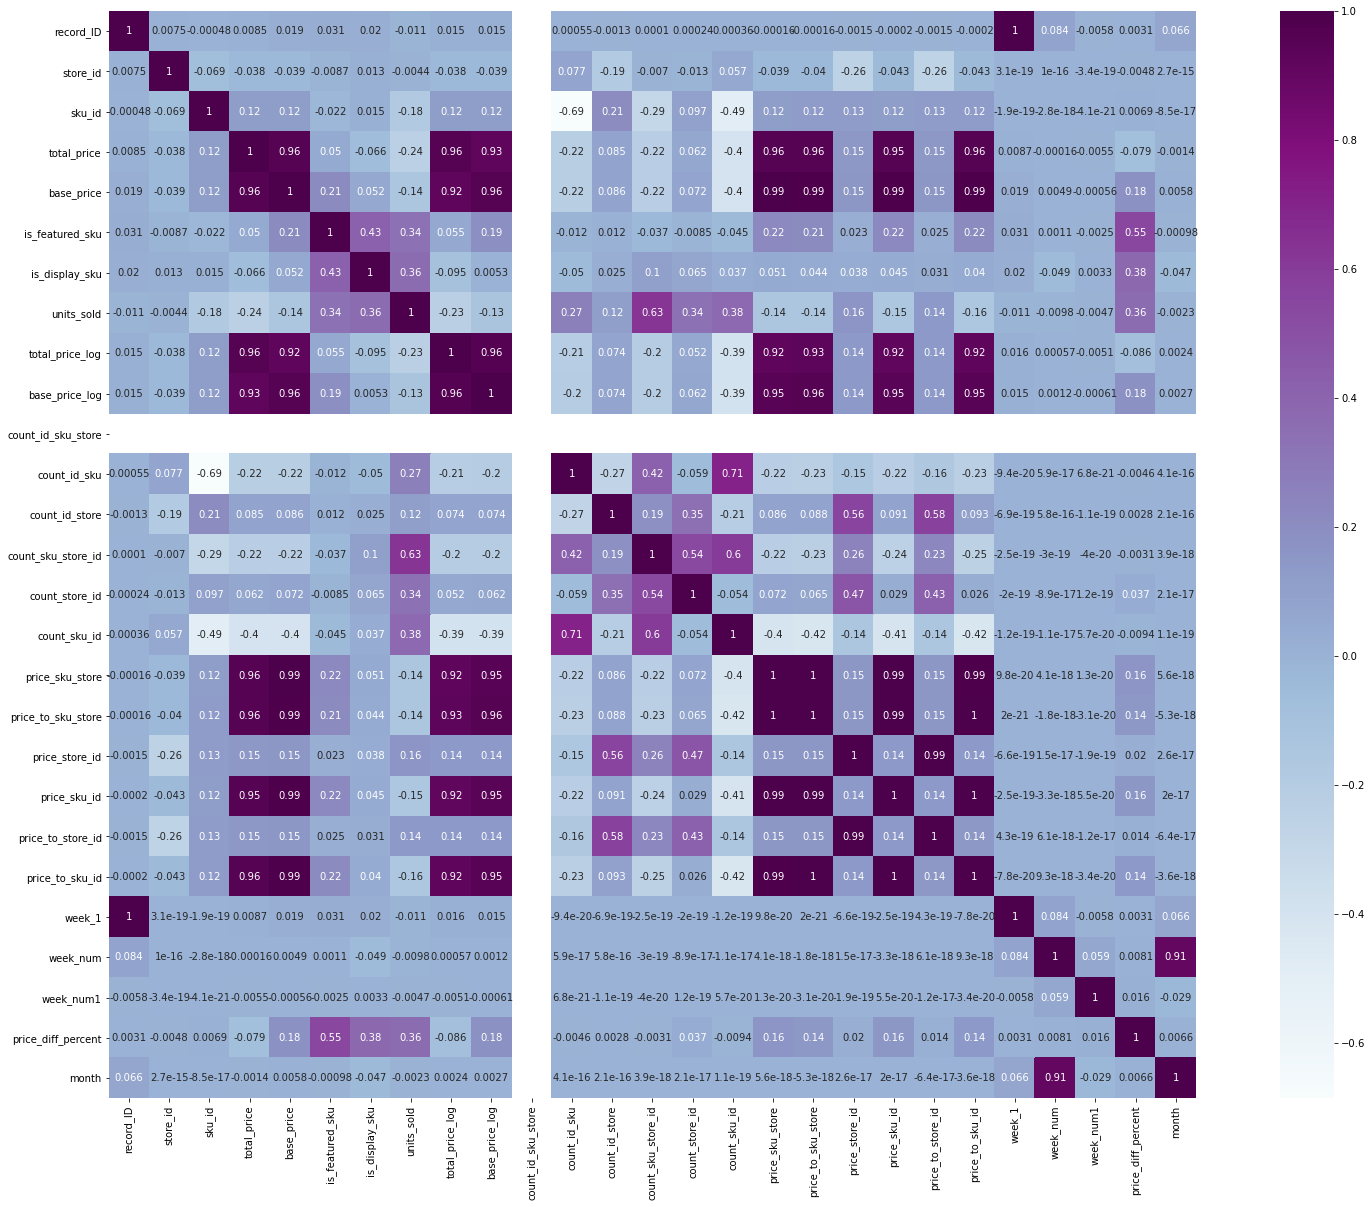

In [38]:
matrix = train.corr()
f, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(matrix, vmax=1, square=True, cmap="BuPu", annot=True)

matrix

# MODEL BUILDING AND TRAINING

In [39]:
X=train[list(set(train.columns)-set(['record_ID','units_sold','week']))]
Y= np.log1p(train['units_sold'])
X_test=test[list(set(test.columns)-set(['record_ID','week']))]

In [40]:
X.dtypes

total_price           float64
month                   int64
price_store_id        float64
price_diff_percent    float64
is_featured_sku         int64
count_store_id        float64
sku_id                  int64
week_1                  int64
store_id                int64
week_num1               int64
total_price_log       float64
count_id_store        float64
base_price_log        float64
price_to_store_id     float64
base_price            float64
count_sku_store_id    float64
is_display_sku          int64
price_to_sku_store    float64
count_id_sku_store    float64
count_sku_id          float64
price_to_sku_id       float64
price_sku_id          float64
price_sku_store       float64
week_num                int64
count_id_sku          float64
dtype: object

In [41]:
X=X.astype({'sku_id': 'category','store_id': 'category'})
X_test=X_test.astype({'sku_id': 'category','store_id': 'category'})

In [42]:
X.dtypes

total_price            float64
month                    int64
price_store_id         float64
price_diff_percent     float64
is_featured_sku          int64
count_store_id         float64
sku_id                category
week_1                   int64
store_id              category
week_num1                int64
total_price_log        float64
count_id_store         float64
base_price_log         float64
price_to_store_id      float64
base_price             float64
count_sku_store_id     float64
is_display_sku           int64
price_to_sku_store     float64
count_id_sku_store     float64
count_sku_id           float64
price_to_sku_id        float64
price_sku_id           float64
price_sku_store        float64
week_num                 int64
count_id_sku           float64
dtype: object

In [43]:
print(len(X_test.columns))
print(len(X.columns))

25
25


In [44]:
category_list=['store_id','sku_id']

In [45]:
X.head()

,total_price,month,price_store_id,price_diff_percent,is_featured_sku,count_store_id,sku_id,week_1,store_id,week_num1,...,count_sku_store_id,is_display_sku,price_to_sku_store,count_id_sku_store,count_sku_id,price_to_sku_id,price_sku_id,price_sku_store,week_num,count_id_sku
0,99.0375,1,181.312372,0.11465,0,32.805983,216418,1,8091,1,...,26.376923,0,102.117692,130.0,88.923869,91.982702,94.688268,105.800769,1,8840.0
1,99.0375,1,181.312372,0.00000,0,32.805983,216419,1,8091,1,...,28.307692,0,102.473942,130.0,72.182664,92.349162,94.908763,105.839135,1,8710.0
2,133.9500,1,181.312372,0.00000,0,32.805983,216425,1,8091,1,...,25.669231,0,126.671538,130.0,34.019231,125.156355,128.285210,131.204135,1,8580.0
3,133.9500,1,181.312372,0.00000,0,32.805983,216233,1,8091,1,...,29.107692,0,126.167308,130.0,46.821206,124.942208,128.101871,129.916154,1,9620.0
4,141.0750,1,181.312372,0.00000,0,32.805983,217390,1,8091,1,...,29.469231,0,152.968269,130.0,62.312747,150.867334,158.990538,164.439519,1,9100.0


In [46]:
encoder_final=MEstimateEncoder()
encoder_final.fit(X[category_list], Y)

cat_enc = encoder_final.transform(X[category_list], Y)
continuous_train = X.drop(columns= category_list)
X = pd.concat([cat_enc,continuous_train],axis=1)

test_enc=encoder_final.transform(X_test[category_list])
continuous_test=X_test.drop(columns= category_list)
X_test=pd.concat([test_enc,continuous_test],axis=1)

In [47]:
X.head()

,store_id,sku_id,total_price,month,price_store_id,price_diff_percent,is_featured_sku,count_store_id,week_1,week_num1,...,count_sku_store_id,is_display_sku,price_to_sku_store,count_id_sku_store,count_sku_id,price_to_sku_id,price_sku_id,price_sku_store,week_num,count_id_sku
0,3.250779,4.201821,99.0375,1,181.312372,0.11465,0,32.805983,1,1,...,26.376923,0,102.117692,130.0,88.923869,91.982702,94.688268,105.800769,1,8840.0
1,3.250779,4.051982,99.0375,1,181.312372,0.00000,0,32.805983,1,1,...,28.307692,0,102.473942,130.0,72.182664,92.349162,94.908763,105.839135,1,8710.0
2,3.250779,3.303344,133.9500,1,181.312372,0.00000,0,32.805983,1,1,...,25.669231,0,126.671538,130.0,34.019231,125.156355,128.285210,131.204135,1,8580.0
3,3.250779,3.715659,133.9500,1,181.312372,0.00000,0,32.805983,1,1,...,29.107692,0,126.167308,130.0,46.821206,124.942208,128.101871,129.916154,1,9620.0
4,3.250779,3.850743,141.0750,1,181.312372,0.00000,0,32.805983,1,1,...,29.469231,0,152.968269,130.0,62.312747,150.867334,158.990538,164.439519,1,9100.0


In [48]:
from sklearn.metrics import mean_squared_error,mean_squared_log_error
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,GridSearchCV,RandomizedSearchCV,cross_val_score,RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import sklearn.ensemble as ensemble
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier

In [49]:
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size = 0.2,random_state=23)

In [50]:
len(x_train.columns)

25

In [51]:

rf_base = RandomForestRegressor()
rf_base.fit(x_train,y_train)


rf_tuned = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=600,
                      n_jobs=None, oob_score=True, random_state=None,
                      verbose=0, warm_start=False)
rf_tuned.fit(x_train,y_train)

RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_split=10,
                      n_estimators=600, oob_score=True)

In [52]:
model_lgb_base=lgb.LGBMRegressor(objective='regression')
model_lgb_base.fit(x_train,y_train)

model_lgb_tuned=lgb.LGBMRegressor(bagging_fraction=0.8, bagging_frequency=4, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
              importance_type='split', learning_rate=0.1, max_depth=30,
              min_child_samples=20, min_child_weight=30, min_data_in_leaf=70,
              min_split_gain=0.0001, n_estimators=200, n_jobs=-1,
              num_leaves=1200, objective=None, random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

model_lgb_tuned.fit(x_train,y_train)

LGBMRegressor(bagging_fraction=0.8, bagging_frequency=4, feature_fraction=0.5,
              max_depth=30, min_child_weight=30, min_data_in_leaf=70,
              min_split_gain=0.0001, n_estimators=200, num_leaves=1200)

In [53]:
prediction_rfb_valid=rf_base.predict(x_valid)
prediction_rft_valid=rf_tuned.predict(x_valid)
prediction_lgbmb_valid=model_lgb_base.predict(x_valid)
prediction_lgbmt_valid=model_lgb_tuned.predict(x_valid)

rf_base_msle=100*mean_squared_log_error(y_valid,prediction_rfb_valid)
rf_tuned_msle=100*mean_squared_log_error(y_valid,prediction_rft_valid)
lgbm_base_msle=100*mean_squared_log_error(y_valid,prediction_lgbmb_valid)
lgbm_tuned_msle=100*mean_squared_log_error(y_valid,prediction_lgbmt_valid)



print("RF Base: {}; RF Tuned: {}".format(rf_base_msle,rf_tuned_msle))
print("LGBM Base: {}; LGBM Tuned: {}".format(lgbm_base_msle,lgbm_tuned_msle))

RF Base: 0.8515039974996934; RF Tuned: 0.8604585564618363
LGBM Base: 0.9012692096166276; LGBM Tuned: 0.72451050827333


In [54]:
model = lgb.LGBMRegressor(bagging_fraction=0.8, bagging_frequency=4, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
              importance_type='split', learning_rate=0.1, max_depth=30,
              min_child_samples=20, min_child_weight=30, min_data_in_leaf=70,
              min_split_gain=0.0001, n_estimators=100, n_jobs=-1,
              num_leaves=1400, objective=None, random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

model.fit(X,Y)

LGBMRegressor(bagging_fraction=0.8, bagging_frequency=4, feature_fraction=0.5,
              max_depth=30, min_child_weight=30, min_data_in_leaf=70,
              min_split_gain=0.0001, num_leaves=1400)

In [55]:
prediction=model.predict(X_test)

In [56]:
prediction

array([2.92617067, 3.12664371, 3.40318683, ..., 3.25601121, 2.55639549,
       2.30437263])

In [57]:
final_prediction=np.round(np.expm1(prediction))

In [58]:
final_prediction

array([18., 22., 29., ..., 25., 12.,  9.])

In [59]:
submission=pd.read_csv('/kaggle/input/demand-forecasting/sample_submission_pzljTaX.csv')

In [61]:
submission['units_sold']=final_prediction

In [62]:
submission.to_csv('/kaggle/working/submit.csv',index=False)

In [64]:
submission.head()

,record_ID,units_sold
0,212645,18.0
1,212646,22.0
2,212647,29.0
3,212648,27.0
4,212649,21.0


In [65]:
test.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,total_price_log,base_price_log,...,price_to_sku_store,price_store_id,price_sku_id,price_to_store_id,price_to_sku_id,week_1,week_num,week_num1,price_diff_percent,month
0,212645,16/07/13,8091,216418,108.3000,108.3000,0,0,4.694096,4.694096,...,102.117692,181.312372,94.688268,172.272756,91.982702,131,27,3,0.0,1
1,212646,16/07/13,8091,216419,109.0125,109.0125,0,0,4.700594,4.700594,...,102.473942,181.312372,94.908763,172.272756,92.349162,131,27,3,0.0,1
2,212647,16/07/13,8091,216425,133.9500,133.9500,0,0,4.904904,4.904904,...,126.671538,181.312372,128.285210,172.272756,125.156355,131,27,3,0.0,1
3,212648,16/07/13,8091,216233,133.9500,133.9500,0,0,4.904904,4.904904,...,126.167308,181.312372,128.101871,172.272756,124.942208,131,27,3,0.0,1
4,212649,16/07/13,8091,217390,176.7000,176.7000,0,0,5.180097,5.180097,...,152.968269,181.312372,158.990538,172.272756,150.867334,131,27,3,0.0,1


In [67]:
test['units_sold']=final_prediction